In [1]:
# Instalações necessárias (caso esteja usando Jupyter Notebook)
%pip install boto3
%pip install pandas
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import io
from datetime import datetime
from datetime import date

In [3]:
# Nome do bucket e do arquivo
BUCKET_NAME = 'bucket-trusted-upa-connect-amanda'
CSV_FILE_TEMP = 'temperatura_ambiente_tratado.csv/part-00000-5e6391e9-725e-4ba5-b1f5-6021fe5c367f-c000.csv'  # ajuste o caminho correto
CSV_FILE_OCUP = 'camera_visao_comp_tratado.csv/part-00000-3f23d9e0-bf3d-41d6-853b-93df47bef4dd-c000.csv'   # ajuste o caminho correto

In [4]:
# Cria o cliente S3
s3 = boto3.client('s3')

# Função para ler CSV do S3
def ler_csv_s3(bucket, key):
    obj = s3.get_object(Bucket=bucket, Key=key)
    df = pd.read_csv(io.BytesIO(obj['Body'].read()))
    return df

/usr/local/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [5]:
# Ler o CSV de temperatura
df_temp = ler_csv_s3(BUCKET_NAME, CSV_FILE_TEMP)
print(df_temp.head())  # Mostra as primeiras linhas

# Ler o CSV de ocupação
df_ocup = ler_csv_s3(BUCKET_NAME, CSV_FILE_OCUP)
print(df_ocup.head())  #

             data_hora  fk_upa  valor
0  2025-04-27 00:00:00       1   22.0
1  2025-04-27 01:00:00       1   21.8
2  2025-04-27 02:00:00       1   21.5
3  2025-04-27 03:00:00       1   21.3
4  2025-04-27 04:00:00       1   21.2
             data_hora  fk_upa  qtd_pessoas
0  2025-04-27 00:00:00       1          2.0
1  2025-04-27 01:00:00       1          1.0
2  2025-04-27 02:00:00       1          1.0
3  2025-04-27 03:00:00       1          0.0
4  2025-04-27 04:00:00       1          0.0


In [6]:
data_especifica = date(2025, 4, 27)

In [7]:
# Funções de busca de dados
def buscar_temperaturas(data_referencia):
    df_temp = ler_csv_s3(BUCKET_NAME, CSV_FILE_TEMP)

    df_temp['data_hora'] = pd.to_datetime(df_temp['data_hora'])
    df_temp = df_temp[df_temp['data_hora'].dt.date == data_referencia]
    
    df_temp['hora'] = df_temp['data_hora'].dt.hour
    df_temp = df_temp.groupby('hora')['valor'].mean().reset_index(name='media_temp')
    return df_temp

In [8]:
def buscar_ocupacao(data_referencia):
    df_ocup = ler_csv_s3(BUCKET_NAME, CSV_FILE_OCUP)

    df_ocup['data_hora'] = pd.to_datetime(df_ocup['data_hora'])
    df_ocup = df_ocup[df_ocup['data_hora'].dt.date == data_referencia]

    df_ocup['hora'] = df_ocup['data_hora'].dt.hour
    df_ocup = df_ocup.groupby('hora')['qtd_pessoas'].mean().reset_index(name='media_ocup')
    return df_ocup

In [9]:
    # Gerar o gráfico
    def ocupacao_temperatura(data_referencia):
        df_temp = buscar_temperaturas(data_referencia)
        df_ocup = buscar_ocupacao(data_referencia)

        if df_temp.empty and df_ocup.empty:
            print(f"Nenhum dado encontrado para o dia {data_referencia.strftime('%d/%m/%Y')}.")
            return

        df_merged = pd.merge(df_ocup, df_temp, on='hora', how='outer').sort_values('hora')
        df_merged = df_merged.fillna(0)

        horas = df_merged['hora']
        ocupacoes = df_merged['media_ocup']
        temperaturas = df_merged['media_temp']

        fig, ax1 = plt.subplots(figsize=(12, 6))

        ax1.bar(horas, ocupacoes, color='cornflowerblue', alpha=0.7, label='Ocupação')
        ax1.set_ylabel('Ocupação', color='blue')
        ax1.set_xlabel('Hora do Dia')
        ax1.set_xticks(range(0, 24))
        ax1.set_xticklabels([str(h) for h in range(0, 24)])

        ax2 = ax1.twinx()
        ax2.plot(horas, temperaturas, color='firebrick', marker='o', label='Temperatura')
        ax2.set_ylabel('Temperatura (°C)', color='red')

        plt.title(f'Ocupação da Sala vs Temperatura - {data_referencia.strftime("%d/%m/%Y")}')
        plt.grid(True)
        fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
        plt.tight_layout()
        plt.show()

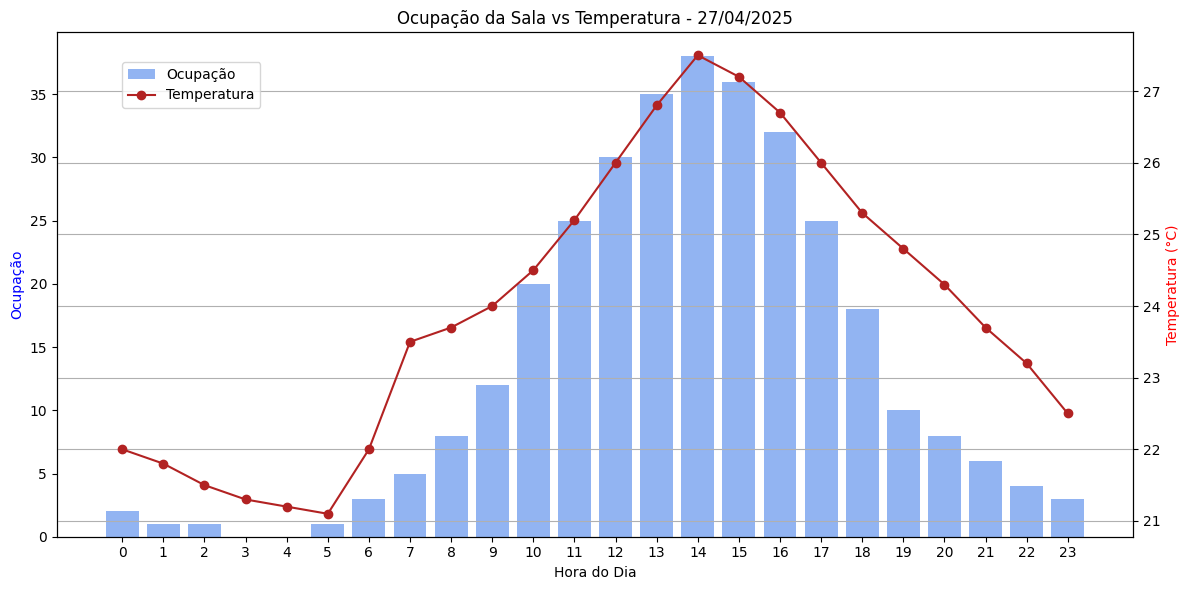

In [10]:
    # Chamada direta
    ocupacao_temperatura(data_especifica)